# Cleaning Airbnb data for Denver

Source of data: http://insideairbnb.com/get-the-data.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

## Listing Data

In [2]:
file_listing = '../../Data/VacationPlanner/listings.csv.gz'
listing = pd.read_csv(file_listing)
print('Number of entries: {:d}'.format(listing.shape[0]))
print('Number of columns: {:d}'.format(listing.shape[1]))
print('The columns are:')
listing.columns

Number of entries: 4984
Number of columns: 96
The columns are:


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

#### Columns of interest:

There are too many columns in the original data set, which are not relevant to the task. So I trim the dataset to the interesting columns that I care about. 




In [3]:
columns = ['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed', 
           'zipcode', 'latitude', 'longitude', 'is_location_exact', 'room_type', 
           'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 
           'cleaning_fee', 'review_scores_rating', 'number_of_reviews']
listing = listing[columns]

# Brief look at the data
listing.head()

,id,host_id,host_is_superhost,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,room_type,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,review_scores_rating,number_of_reviews
0,360,666,t,Highland,80211.0,39.767033,-105.002564,t,Entire home/apt,5,1.0,2,2.0,$140.00,$35.00,100.0,3
1,590,933,t,North Park Hill,80207.0,39.753609,-104.912373,t,Private room,3,1.0,1,1.0,$61.00,$10.00,96.0,540
2,592,933,t,North Park Hill,80207.0,39.754380,-104.911557,t,Private room,2,1.0,1,1.0,$42.00,$10.00,97.0,142
3,686,990,t,North Capitol Hill,80203.0,39.745030,-104.977564,t,Private room,2,2.0,1,1.0,$70.00,$10.00,95.0,232
4,1940,2150,t,Baker,80223.0,39.719810,-104.996487,t,Entire home/apt,2,1.0,0,1.0,$95.00,$75.00,99.0,21


In [4]:
# Columns types
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 17 columns):
id                        4984 non-null int64
host_id                   4984 non-null int64
host_is_superhost         4984 non-null object
neighbourhood_cleansed    4984 non-null object
zipcode                   4916 non-null float64
latitude                  4984 non-null float64
longitude                 4984 non-null float64
is_location_exact         4984 non-null object
room_type                 4984 non-null object
accommodates              4984 non-null int64
bathrooms                 4981 non-null float64
bedrooms                  4984 non-null int64
beds                      4982 non-null float64
price                     4984 non-null object
cleaning_fee              4350 non-null object
review_scores_rating      4338 non-null float64
number_of_reviews         4984 non-null int64
dtypes: float64(6), int64(5), object(6)
memory usage: 662.0+ KB


### Missing entries

Count the number of missing entry in each column

In [5]:
# No of missing entries in each columns
print('Number of entries is {0:d} '.format(listing.shape[0]))

listing.isnull().sum()

Number of entries is 4984 


id                          0
host_id                     0
host_is_superhost           0
neighbourhood_cleansed      0
zipcode                    68
latitude                    0
longitude                   0
is_location_exact           0
room_type                   0
accommodates                0
bathrooms                   3
bedrooms                    0
beds                        2
price                       0
cleaning_fee              634
review_scores_rating      646
number_of_reviews           0
dtype: int64

### Data Cleaning

1. Drop the column zipcode and is_location_exact. Location information from latitude, longitude and neighbourhood_cleansed should be sufficient for the task.
2. Drop entries with missing values in bathrooms and beds.
3. Replane Nan in cleaning_fee to 0
4. Replace host_is_superhost values with t:1 and f:0
5. Format price and cleaning_fee to float. 
6. Set id as dataframe index
7. Remove luxury listing (price >9998)

In [6]:
# Drop zipcode and is_location_exact column
listing = listing.drop(columns=['zipcode', 'is_location_exact'])

# Drop entries with missing values in bathrooms and beds
og_len = listing.shape[0]
listing = listing.dropna(how='any', subset=['bathrooms', 'beds'])


# Replace NaN in cleaning price
listing['cleaning_fee'] = listing['cleaning_fee'].fillna('0')

# Make host_is_superhost binary
listing = listing.replace({'host_is_superhost':{'t':1, 'f':0}})

# Format price and cleaning_free
listing[['price', 'cleaning_fee']] = listing[['price', 'cleaning_fee']].replace(
                                    '[\$,]', '', regex=True).astype(float)

# Remove luxury entries
listing = listing[listing['price']<9998]
print('Number of entries dropped: {0:d}'.format(og_len - listing.shape[0]))
print('Number of remaining entries: {0:d}'.format(listing.shape[0]))

# Set id as index
listing = listing.set_index('id')

Number of entries dropped: 13
Number of remaining entries: 4971


## Calendar data

In [7]:
file_calendar = '../../Data/VacationPlanner/calendar.csv.gz'
calendar = pd.read_csv(file_calendar)
print('Number of entries: {:d}'.format(calendar.shape[0]))
print('Number of columns: {:d}'.format(calendar.shape[1]))
print('The columns are:')
calendar.head()

Number of entries: 1819160
Number of columns: 4
The columns are:


,listing_id,date,available,price
0,360,2019-08-22,t,$149.00
1,360,2019-08-21,t,$149.00
2,360,2019-08-20,t,$149.00
3,360,2019-08-19,t,$149.00
4,360,2019-08-18,t,$149.00


### Missing entries

In [8]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price         1112781
dtype: int64

### Data cleaning

1. Drop available. Available has t or f values. When available == 'f', price shows a NaN value. So available is redundant
2. Drop all entries with NaN
3. Convert price to numeric format
4. Convert data to numpy date time format
5. Rename listing_id to id

In [9]:
# Drop available
calendar = calendar.drop(columns=['available'])

# Drop NaN entries
og_len = calendar.shape[0]
calendar = calendar.dropna(how='any', subset=['price'])
print('Number of entries dropped: {0:d}'.format(og_len - calendar.shape[0]))
print('Number of remaining entries: {0:d}'.format(listing.shape[0]))

# Format price and cleaning_free
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert date-time format
calendar['date'] = pd.to_datetime(calendar['date'], yearfirst=True)

# Rename 
calendar = calendar.rename(index=str, columns={'listing_id': 'id'});
calendar.info()

Number of entries dropped: 1112781
Number of remaining entries: 4971
<class 'pandas.core.frame.DataFrame'>
Index: 706379 entries, 0 to 1819151
Data columns (total 3 columns):
id       706379 non-null int64
date     706379 non-null datetime64[ns]
price    706379 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 21.6+ MB


In [10]:
calendar.groupby(['date']).size().reset_index(name='counts').head(5)

,date,counts
0,2018-08-27,1093
1,2018-08-28,1315
2,2018-08-29,1305
3,2018-08-30,1006
4,2018-08-31,635


In [11]:
median_price = calendar.groupby('id')['price'].median().reset_index(name='price')
median_price = median_price.set_index('id')

## Data Exploration

Trying to look at some general trends and structure in the data. While also gaining some insight into the data

##### Number of apartments vs accomodates

We can observe that apartments with accomodates of multiple of two are more popular. I would guess that this is because most listing would use a standard bed which accommodates two people. So the number of accommodates goes along with it. And fewer apartments have bed/couch for single person. 

Text(0,0.5,'Number of listing')

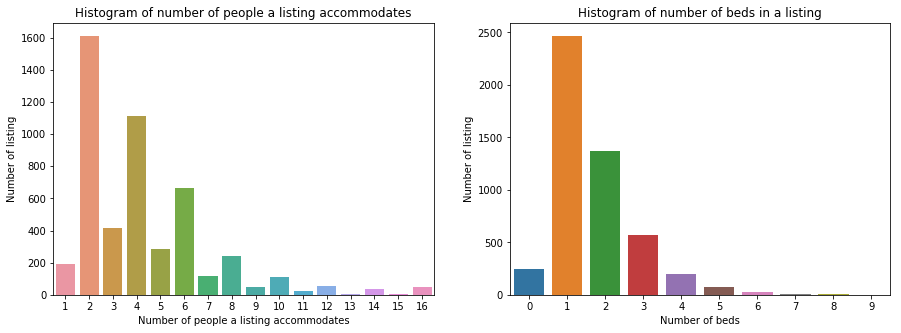

In [12]:
f, axs = plt.subplots(1,2,figsize=(15,5));

# Subplot 1 (Error in eigen_value)
sns.countplot(x='accommodates', data=listing, ax=axs[0])
axs[0].set_title('Histogram of number of people a listing accommodates')
axs[0].set_xlabel('Number of people a listing accommodates')
axs[0].set_ylabel('Number of listing')

# # Subplot 2 (Error in eigen_ec)
sns.countplot(x='bedrooms', data=listing, ax=axs[1])
axs[1].set_title('Histogram of number of beds in a listing')
axs[1].set_xlabel('Number of beds')
axs[1].set_ylabel('Number of listing')

#### Histogram of number of bathrooms

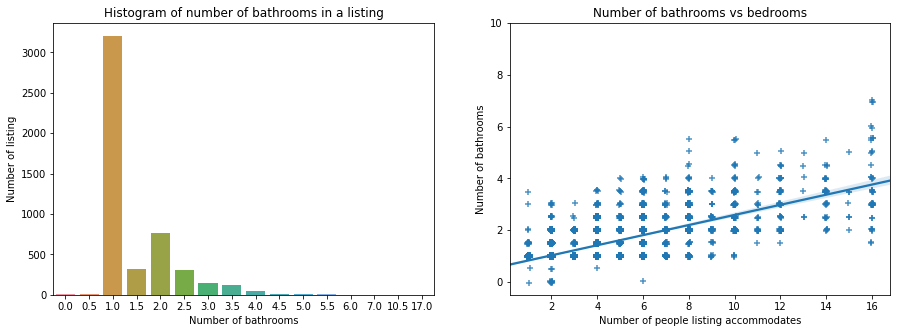

In [13]:
f, axs = plt.subplots(1,2,figsize=(15,5));

# Subplot 1 (Error in eigen_value)
sns.countplot(x='bathrooms', data=listing, ax=axs[0])
axs[0].set_title('Histogram of number of bathrooms in a listing')
axs[0].set_xlabel('Number of bathrooms')
axs[0].set_ylabel('Number of listing')

# # Subplot 2 (Error in eigen_ec)
sns.regplot(x='accommodates', y='bathrooms', data=listing, ax=axs[1], marker='+', x_jitter=0.05, y_jitter=0.05)
axs[1].set_title('Number of bathrooms vs bedrooms')
axs[1].set_xlabel('Number of people listing accommodates')
axs[1].set_ylabel('Number of bathrooms')
axs[1].set_ylim([-0.5, 10]);

#### Price distribution

Price is a function of number of people or number of bed in an apartment. So will fix each quantity and see how the price varies.

Note: Travel with your friends. It is more fun and cheaper. Win-win! :-)

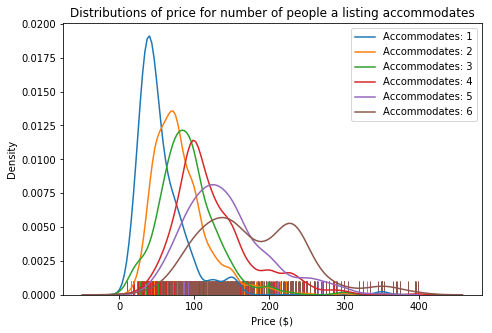

In [14]:
plt.figure(figsize=(7.5,5))
for no_people in range(1,7):
    sns.distplot(listing[(listing['price']<400) & (listing['accommodates'] == no_people)]['price'],
             bins=30, kde=True, hist=False, rug=True, label='Accommodates: {:d}'.format(no_people))
plt.xlabel('Price ($)');
plt.ylabel('Density');
plt.title('Distributions of price for number of people a listing accommodates');

#### Geographical location price

#### Quantities correlating with price

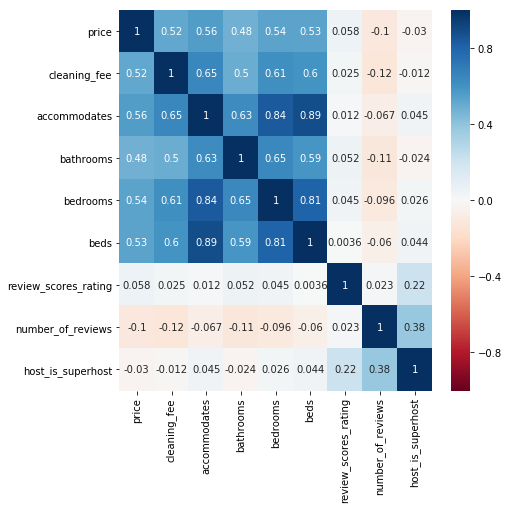

In [15]:
select_col = ['price', 'cleaning_fee', 'accommodates', 'bathrooms', 'bedrooms',
             'beds', 'review_scores_rating', 'number_of_reviews', 'host_is_superhost']
corrmat = listing[select_col].corr()
plt.figure(figsize=(7,7))
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap="RdBu");

#### Price seasonality

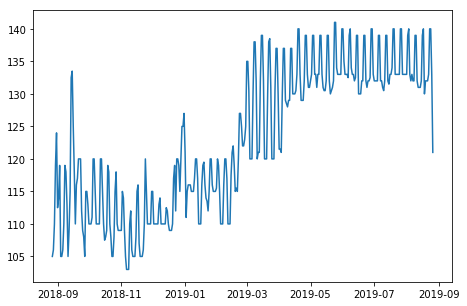

In [16]:
median_price = calendar.groupby('date')['price'].median().reset_index(name='price')
# median_price.set_index('date')
# sns.lineplot(x='date', y='price', data='median_price')
# sns.lineplot(median_price)
plt.figure(figsize=(7.5,5))
plt.plot(median_price['date'], median_price['price'])

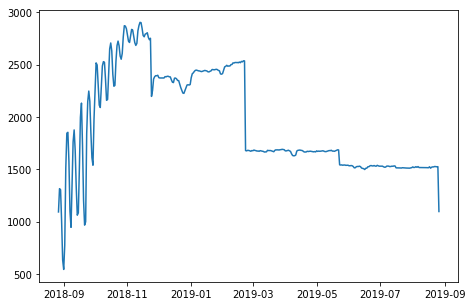

In [19]:
median_price = calendar.groupby('date')['price'].count().reset_index(name='price')
# median_price.set_index('date')
# sns.lineplot(x='date', y='price', data='median_price')
# sns.lineplot(median_price)
plt.figure(figsize=(7.5,5))
plt.plot(median_price['date'], median_price['price'])